# Spatial Autoregressive Analysis for Rent Growth

This notebook applies spatial autoregressive (SAR) modeling to rental price panel data across Victorian suburbs.

## Objectives
- Load preprocessed panel data with spatial features from feature engineering notebook
- Apply spatial connectivity matrix to model spatial dependencies
- Fit and compare OLS, WLS, and SAR models
- Visualize spatial and temporal patterns in rental prices


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.regression.linear_model import WLS
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries loaded successfully")


Libraries loaded successfully


## 1. Load Preprocessed Data from Feature Engineering


In [11]:
# Load cleaned dataset from feature engineering notebook
df_clean = pd.read_pickle('../data/curated/rent_growth/df_clean.pkl')

# Convert date to datetime if needed
df_clean['date'] = pd.to_datetime(df_clean['date'])

print(f"Dataset loaded successfully")
print(f"Shape: {df_clean.shape}")
print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")
print(f"\nOriginal median_rent statistics:")
print(df_clean['median_rent'].describe())


Dataset loaded successfully
Shape: (38528, 32)
Date range: 2013-06-01 00:00:00 to 2025-03-01 00:00:00

Original median_rent statistics:
count    38528.000000
mean       455.935190
std        193.352361
min        115.000000
25%        330.000000
50%        405.000000
75%        540.000000
max       1975.000000
Name: median_rent, dtype: float64


In [12]:
# One-hot encode property_type
print("One-hot encoding property_type...")
property_dummies = pd.get_dummies(df_clean['property_type'], prefix='property', drop_first=True, dtype=np.float64)

# Add to dataframe
df_clean = pd.concat([df_clean, property_dummies], axis=1)

# Ensure property dummies are float64
for col in property_dummies.columns:
    df_clean[col] = df_clean[col].astype(np.float64)

print(f"Created {len(property_dummies.columns)} property type dummy variables:")
print(f"  {list(property_dummies.columns)}")
print(f"\nProperty type distribution:")
print(df_clean['property_type'].value_counts())


One-hot encoding property_type...
Created 5 property type dummy variables:
  ['property_2 bedroom flat', 'property_2 bedroom house', 'property_3 bedroom flat', 'property_3 bedroom house', 'property_4 bedroom house']

Property type distribution:
property_type
2 bedroom flat     6584
3 bedroom house    6534
4 bedroom house    6452
3 bedroom flat     6394
2 bedroom house    6390
1 bedroom flat     6174
Name: count, dtype: int64


## 2. Exploratory Data Analysis


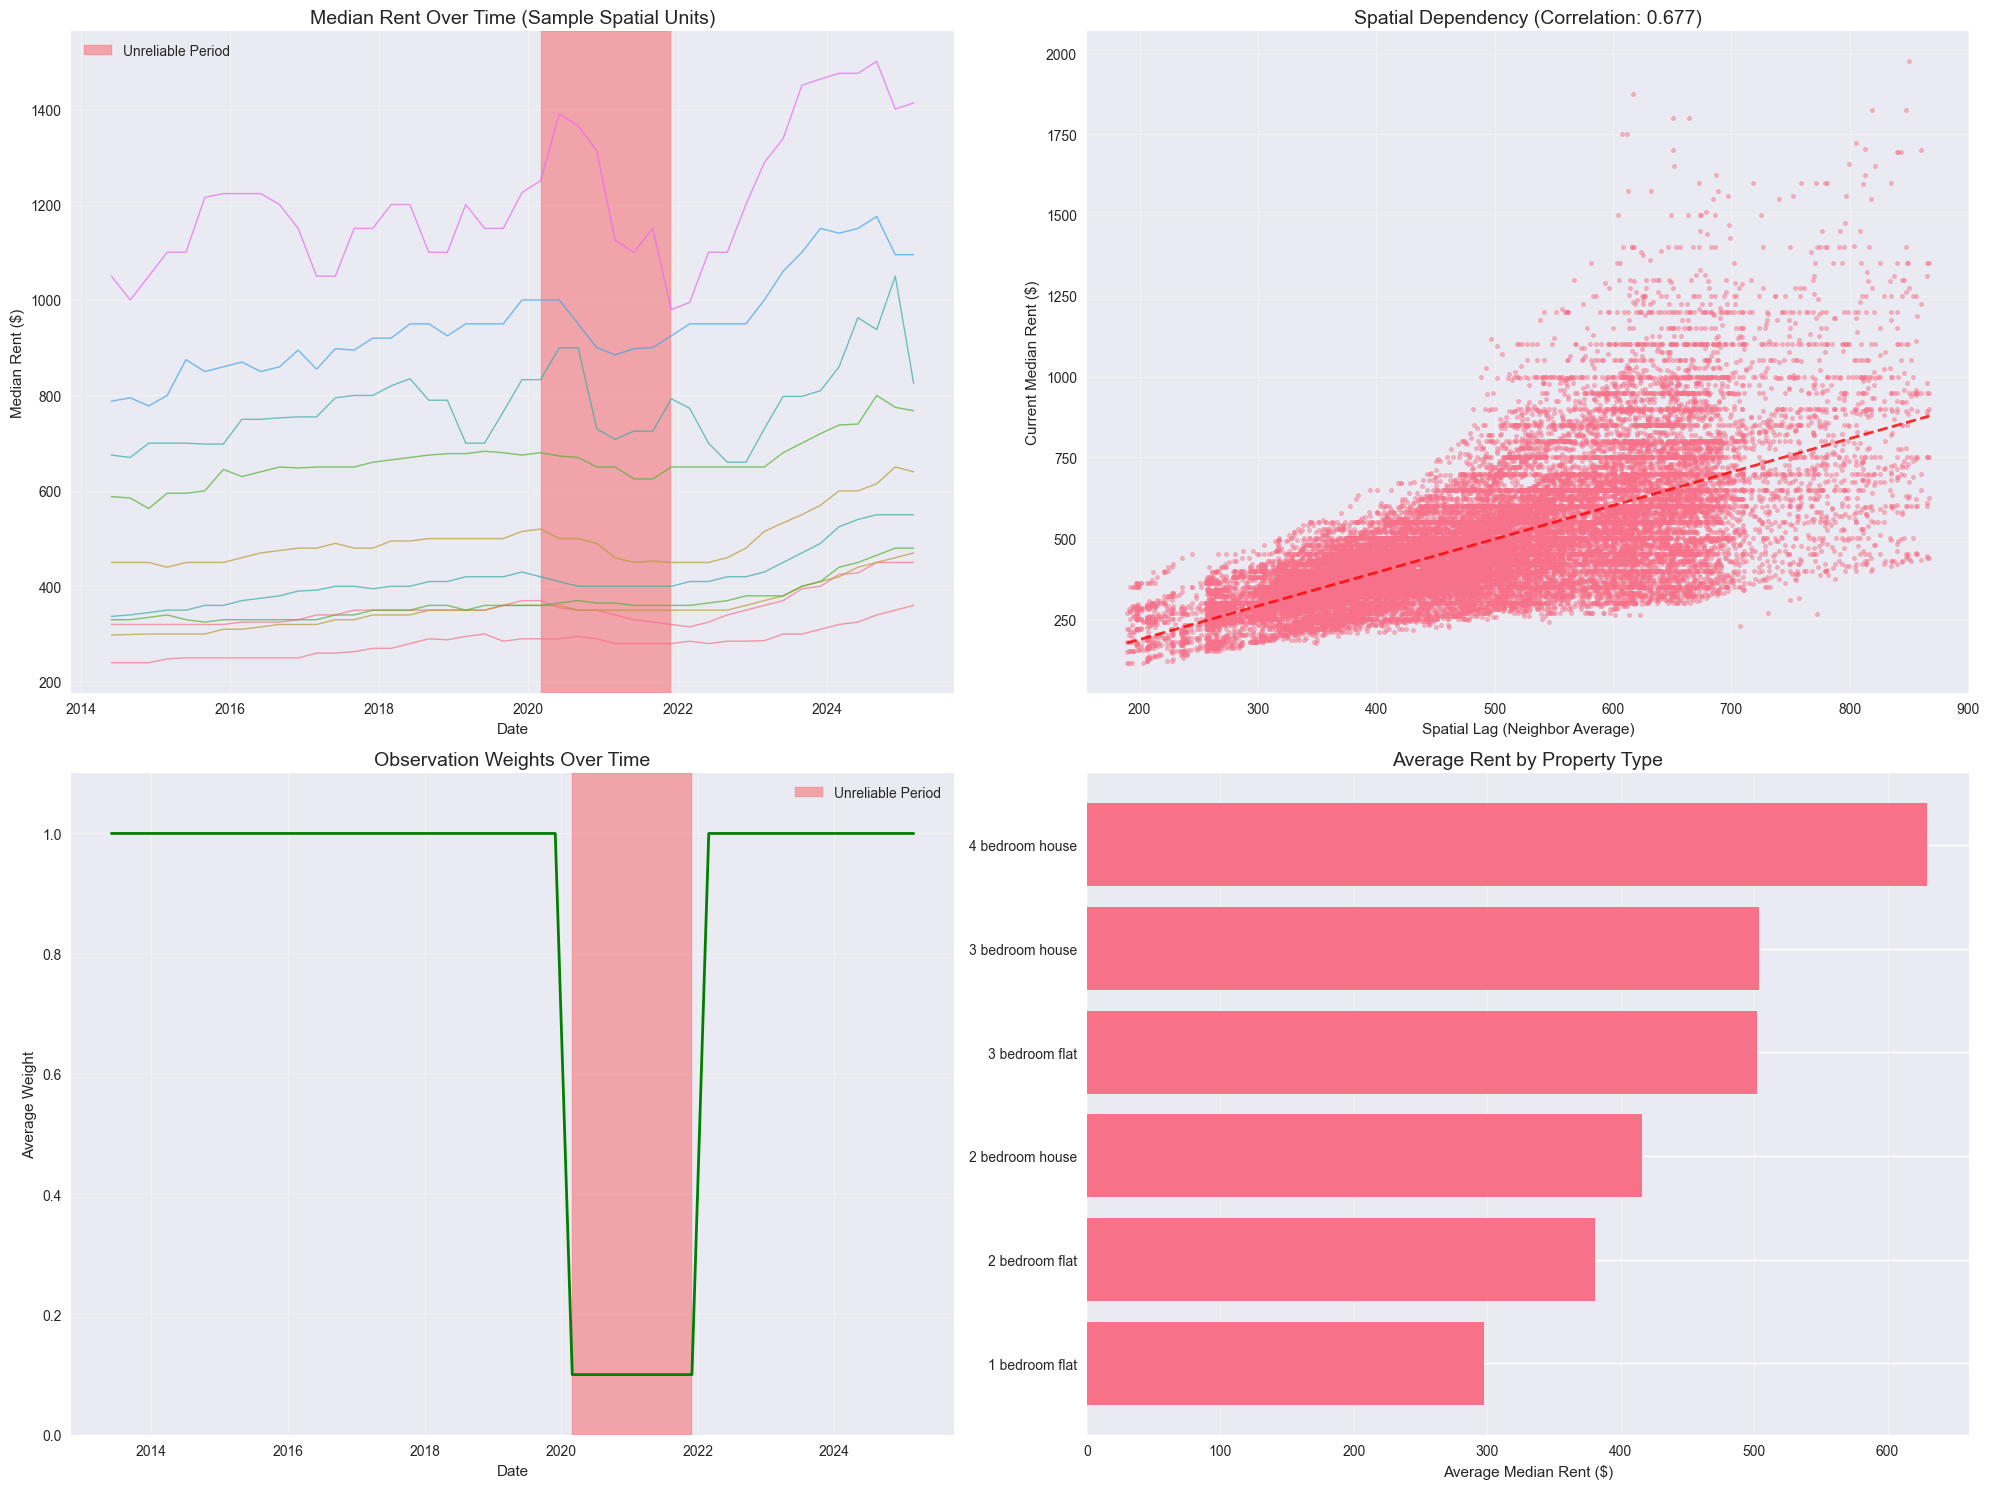

In [13]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Plot 1: Time series for sample spatial units
sample_units = df_clean['spatial_unit'].unique()[:10]
for unit in sample_units:
    unit_data = df_clean[df_clean['spatial_unit'] == unit]
    axes[0, 0].plot(unit_data['date'], unit_data['median_rent'], 
                   alpha=0.7, linewidth=1)

# Highlight unreliable period
unreliable_dates = df_clean[df_clean['is_unreliable']]['date'].unique()
if len(unreliable_dates) > 0:
    axes[0, 0].axvspan(unreliable_dates.min(), unreliable_dates.max(), 
                      alpha=0.3, color='red', label='Unreliable Period')

axes[0, 0].set_title('Median Rent Over Time (Sample Spatial Units)', fontsize=14)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Median Rent ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Spatial lag vs current rent
if df_clean['spatial_lag'].sum() > 0:
    df_with_spatial = df_clean[df_clean['spatial_lag'] > 0]
    spatial_corr = df_with_spatial[['median_rent', 'spatial_lag']].corr().iloc[0, 1]
    axes[0, 1].scatter(df_with_spatial['spatial_lag'], df_with_spatial['median_rent'], 
                      alpha=0.5, s=10)
    axes[0, 1].set_xlabel('Spatial Lag (Neighbor Average)')
    axes[0, 1].set_ylabel('Current Median Rent ($)')
    axes[0, 1].set_title(f'Spatial Dependency (Correlation: {spatial_corr:.3f})', fontsize=14)
    
    # Add trend line
    z = np.polyfit(df_with_spatial['spatial_lag'], df_with_spatial['median_rent'], 1)
    p = np.poly1d(z)
    x_line = np.array([df_with_spatial['spatial_lag'].min(), 
                       df_with_spatial['spatial_lag'].max()])
    axes[0, 1].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
else:
    axes[0, 1].text(0.5, 0.5, 'No spatial connectivity detected\n(Matrix is all zeros)', 
                   ha='center', va='center', fontsize=12, transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Spatial Dependency', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Weights over time
weights_by_time = df_clean.groupby('date')['weights'].mean()
axes[1, 0].plot(weights_by_time.index, weights_by_time.values, 'g-', linewidth=2)
if len(unreliable_dates) > 0:
    axes[1, 0].axvspan(unreliable_dates.min(), unreliable_dates.max(), 
                      alpha=0.3, color='red', label='Unreliable Period')
axes[1, 0].set_title('Observation Weights Over Time', fontsize=14)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Average Weight')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 1.1)

# Plot 4: Rent distribution by property type
if 'property_type' in df_clean.columns:
    property_means = df_clean.groupby('property_type')['median_rent'].mean().sort_values()
    axes[1, 1].barh(range(len(property_means)), property_means.values)
    axes[1, 1].set_yticks(range(len(property_means)))
    axes[1, 1].set_yticklabels(property_means.index)
    axes[1, 1].set_xlabel('Average Median Rent ($)')
    axes[1, 1].set_title('Average Rent by Property Type', fontsize=14)
else:
    # Show suburb variation instead
    suburb_means = df_clean.groupby('suburb')['median_rent'].mean().sort_values(ascending=False).head(15)
    axes[1, 1].barh(range(len(suburb_means)), suburb_means.values)
    axes[1, 1].set_yticks(range(len(suburb_means)))
    axes[1, 1].set_yticklabels(suburb_means.index)
    axes[1, 1].set_xlabel('Average Median Rent ($)')
    axes[1, 1].set_title('Top 15 Suburbs by Average Rent', fontsize=14)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [14]:
# Define feature sets
basic_lag_features = ['rent_lag_1', 'rent_lag_2', 'rent_lag_3', 'rent_lag_4']

# Check if spatial_lag has meaningful values
spatial_lag_exists = ('spatial_lag' in df_clean.columns and 
                     df_clean['spatial_lag'].notna().any() and
                     (df_clean['spatial_lag'] > 0).sum() > 0)

spatial_features = ['spatial_lag'] if spatial_lag_exists else []

# Economic and demographic features
economic_features = ['cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 
                    'population', 'median_personal_income']
available_econ_features = [f for f in economic_features if f in df_clean.columns]

# Property type one-hot encoded features (exclude the original 'property_type' string column)
property_type_features = [col for col in df_clean.columns if col.startswith('property_') and col != 'property_type']

# Combine all features
all_features = basic_lag_features + spatial_features + available_econ_features + property_type_features

print("Feature sets:")
print(f"  Basic lag features: {basic_lag_features}")
if spatial_features:
    spatial_obs_count = (df_clean['spatial_lag'] > 0).sum()
    print(f"  Spatial features: {spatial_features} ({spatial_obs_count} non-zero observations)")
else:
    print(f"  Spatial features: None (no spatial connectivity detected)")
print(f"  Economic features: {available_econ_features}")
print(f"  Property type features: {property_type_features}")
print(f"  All features ({len(all_features)}): {all_features}")


Feature sets:
  Basic lag features: ['rent_lag_1', 'rent_lag_2', 'rent_lag_3', 'rent_lag_4']
  Spatial features: ['spatial_lag'] (28635 non-zero observations)
  Economic features: ['cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 'population', 'median_personal_income']
  Property type features: ['property_2 bedroom flat', 'property_2 bedroom house', 'property_3 bedroom flat', 'property_3 bedroom house', 'property_4 bedroom house']
  All features (16): ['rent_lag_1', 'rent_lag_2', 'rent_lag_3', 'rent_lag_4', 'spatial_lag', 'cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 'population', 'median_personal_income', 'property_2 bedroom flat', 'property_2 bedroom house', 'property_3 bedroom flat', 'property_3 bedroom house', 'property_4 bedroom house']


## 3. Temporal Train/Test Split

For proper model validation, we split the data temporally to evaluate out-of-sample performance.


TEMPORAL TRAIN/TEST SPLIT

Split date: 2024-01-01

Set        Observations    Date Range                               % of Total
------------------------------------------------------------
Train      34180           2013-06-01 to <20 88.7%
Test       4348            2024-03-01 to <20 11.3%
Total      38528          

Train set:
  Spatial units: 845
  Time periods: 43
  Median rent: $440.78 ± $184.49

Test set:
  Spatial units: 837
  Time periods: 5
  Median rent: $575.04 ± $218.44


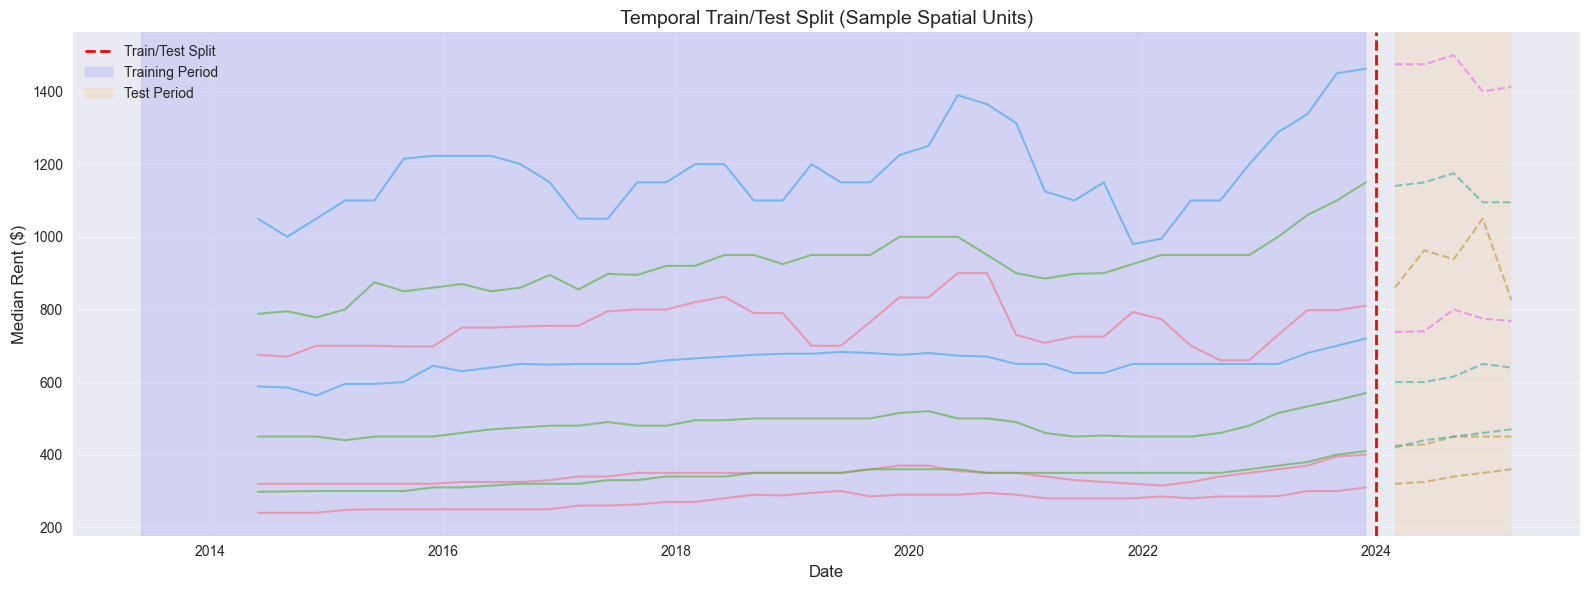

In [15]:
# Define temporal split point
# Train on data up to end of 2023, test on 2024-2025
split_date = pd.to_datetime('2024-01-01')

df_train = df_clean[df_clean['date'] < split_date].copy()
df_test = df_clean[df_clean['date'] >= split_date].copy()

print("=" * 60)
print("TEMPORAL TRAIN/TEST SPLIT")
print("=" * 60)
print(f"\nSplit date: {split_date.date()}")
print(f"\n{'Set':<10} {'Observations':<15} {'Date Range':<40} {'% of Total':<10}")
print("-" * 60)
print(f"{'Train':<10} {len(df_train):<15} {df_train['date'].min().date()} to {df_train['date'].max().date():<20} {100*len(df_train)/len(df_clean):.1f}%")
print(f"{'Test':<10} {len(df_test):<15} {df_test['date'].min().date()} to {df_test['date'].max().date():<20} {100*len(df_test)/len(df_clean):.1f}%")
print(f"{'Total':<10} {len(df_clean):<15}")
print("=" * 60)

print(f"\nTrain set:")
print(f"  Spatial units: {df_train['spatial_unit'].nunique()}")
print(f"  Time periods: {df_train['time_index'].nunique()}")
print(f"  Median rent: ${df_train['median_rent'].mean():.2f} ± ${df_train['median_rent'].std():.2f}")

print(f"\nTest set:")
print(f"  Spatial units: {df_test['spatial_unit'].nunique()}")
print(f"  Time periods: {df_test['time_index'].nunique()}")
print(f"  Median rent: ${df_test['median_rent'].mean():.2f} ± ${df_test['median_rent'].std():.2f}")

# Visualize the split
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# Plot a few sample time series
sample_units = df_clean['spatial_unit'].unique()[:8]
for unit in sample_units:
    unit_train = df_train[df_train['spatial_unit'] == unit]
    unit_test = df_test[df_test['spatial_unit'] == unit]
    
    if not unit_train.empty:
        ax.plot(unit_train['date'], unit_train['median_rent'], alpha=0.6, linewidth=1.5)
    if not unit_test.empty:
        ax.plot(unit_test['date'], unit_test['median_rent'], alpha=0.6, linewidth=1.5, linestyle='--')

# Add vertical line at split
ax.axvline(x=split_date, color='red', linestyle='--', linewidth=2, label='Train/Test Split')
ax.axvspan(df_train['date'].min(), df_train['date'].max(), alpha=0.1, color='blue', label='Training Period')
ax.axvspan(df_test['date'].min(), df_test['date'].max(), alpha=0.1, color='orange', label='Test Period')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Median Rent ($)', fontsize=12)
ax.set_title('Temporal Train/Test Split (Sample Spatial Units)', fontsize=14)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# Prepare training data
X_train = df_train[all_features].values
y_train = df_train['median_rent'].values
w_train = df_train['weights'].values
X_train_const = sm.add_constant(X_train)

# Prepare test data
X_test = df_test[all_features].values
y_test = df_test['median_rent'].values
w_test = df_test['weights'].values
X_test_const = sm.add_constant(X_test)

print("=" * 60)
print("DATA PREPARATION FOR MODELING")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  Feature matrix shape: {X_train_const.shape}")
print(f"  Target vector shape: {y_train.shape}")
print(f"  Weights shape: {w_train.shape}")
print(f"  Target statistics: Mean=${y_train.mean():.2f}, Std=${y_train.std():.2f}")

print(f"\nTest Set:")
print(f"  Feature matrix shape: {X_test_const.shape}")
print(f"  Target vector shape: {y_test.shape}")
print(f"  Weights shape: {w_test.shape}")
print(f"  Target statistics: Mean=${y_test.mean():.2f}, Std=${y_test.std():.2f}")

print(f"\nFeatures ({len(all_features)}): {all_features}")
print("=" * 60)


DATA PREPARATION FOR MODELING

Training Set:
  Feature matrix shape: (34180, 17)
  Target vector shape: (34180,)
  Weights shape: (34180,)
  Target statistics: Mean=$440.78, Std=$184.49

Test Set:
  Feature matrix shape: (4348, 17)
  Target vector shape: (4348,)
  Weights shape: (4348,)
  Target statistics: Mean=$575.04, Std=$218.41

Features (16): ['rent_lag_1', 'rent_lag_2', 'rent_lag_3', 'rent_lag_4', 'spatial_lag', 'cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 'population', 'median_personal_income', 'property_2 bedroom flat', 'property_2 bedroom house', 'property_3 bedroom flat', 'property_3 bedroom house', 'property_4 bedroom house']


## 4. Fit and Evaluate Models

We fit models on the training set and evaluate on both training (in-sample) and test (out-of-sample) sets.


In [17]:
print("Fitting models on TRAINING data...\n")

# 1. Ordinary Least Squares (OLS)
print("1. Fitting OLS model...")
ols_model = sm.OLS(y_train, X_train_const).fit()

# Training predictions and metrics
ols_train_pred = ols_model.predict(X_train_const)
ols_train_r2 = r2_score(y_train, ols_train_pred)
ols_train_rmse = np.sqrt(mean_squared_error(y_train, ols_train_pred))
ols_train_mae = mean_absolute_error(y_train, ols_train_pred)

# Test predictions and metrics (out-of-sample)
ols_test_pred = ols_model.predict(X_test_const)
ols_test_r2 = r2_score(y_test, ols_test_pred)
ols_test_rmse = np.sqrt(mean_squared_error(y_test, ols_test_pred))
ols_test_mae = mean_absolute_error(y_test, ols_test_pred)

print(f"   Train: R²={ols_train_r2:.4f}, RMSE=${ols_train_rmse:.2f}, MAE=${ols_train_mae:.2f}")
print(f"   Test:  R²={ols_test_r2:.4f}, RMSE=${ols_test_rmse:.2f}, MAE=${ols_test_mae:.2f}")

# 2. Weighted Least Squares (WLS)
print("\n2. Fitting WLS model...")
wls_model = WLS(y_train, X_train_const, weights=w_train).fit()

# Training predictions and metrics
wls_train_pred = wls_model.predict(X_train_const)
wls_train_r2 = r2_score(y_train, wls_train_pred)
wls_train_rmse = np.sqrt(mean_squared_error(y_train, wls_train_pred))
wls_train_mae = mean_absolute_error(y_train, wls_train_pred)

# Test predictions and metrics (out-of-sample)
wls_test_pred = wls_model.predict(X_test_const)
wls_test_r2 = r2_score(y_test, wls_test_pred)
wls_test_rmse = np.sqrt(mean_squared_error(y_test, wls_test_pred))
wls_test_mae = mean_absolute_error(y_test, wls_test_pred)

print(f"   Train: R²={wls_train_r2:.4f}, RMSE=${wls_train_rmse:.2f}, MAE=${wls_train_mae:.2f}")
print(f"   Test:  R²={wls_test_r2:.4f}, RMSE=${wls_test_rmse:.2f}, MAE=${wls_test_mae:.2f}")

print("\n" + "=" * 60)
print("Models fitted successfully!")
print("=" * 60)


Fitting models on TRAINING data...

1. Fitting OLS model...
   Train: R²=0.9927, RMSE=$15.75, MAE=$8.21
   Test:  R²=0.9904, RMSE=$21.45, MAE=$13.01

2. Fitting WLS model...
   Train: R²=0.9927, RMSE=$15.78, MAE=$8.26
   Test:  R²=0.9902, RMSE=$21.62, MAE=$13.42

Models fitted successfully!


In [18]:
# Model comparison summary
print("=" * 80)
print("MODEL COMPARISON SUMMARY - TRAIN vs TEST PERFORMANCE")
print("=" * 80)

print("\n" + "=" * 80)
print("TRAINING SET PERFORMANCE (In-Sample)")
print("=" * 80)
print(f"{'Model':<20} {'R²':<12} {'RMSE':<12} {'MAE':<12}")
print("-" * 80)
print(f"{'OLS':<20} {ols_train_r2:<12.4f} ${ols_train_rmse:<11.2f} ${ols_train_mae:<11.2f}")
print(f"{'WLS':<20} {wls_train_r2:<12.4f} ${wls_train_rmse:<11.2f} ${wls_train_mae:<11.2f}")
print("=" * 80)

print("\n" + "=" * 80)
print("TEST SET PERFORMANCE (Out-of-Sample)")
print("=" * 80)
print(f"{'Model':<20} {'R²':<12} {'RMSE':<12} {'MAE':<12}")
print("-" * 80)
print(f"{'OLS':<20} {ols_test_r2:<12.4f} ${ols_test_rmse:<11.2f} ${ols_test_mae:<11.2f}")
print(f"{'WLS':<20} {wls_test_r2:<12.4f} ${wls_test_rmse:<11.2f} ${wls_test_mae:<11.2f}")
print("=" * 80)

# Calculate performance degradation
print("\n" + "=" * 80)
print("GENERALIZATION GAP (Train R² - Test R²)")
print("=" * 80)
ols_gap = ols_train_r2 - ols_test_r2
wls_gap = wls_train_r2 - wls_test_r2
print(f"{'Model':<20} {'Train R²':<12} {'Test R²':<12} {'Gap':<12} {'Gap %':<12}")
print("-" * 80)
print(f"{'OLS':<20} {ols_train_r2:<12.4f} {ols_test_r2:<12.4f} {ols_gap:<12.4f} {100*ols_gap/ols_train_r2:<11.2f}%")
print(f"{'WLS':<20} {wls_train_r2:<12.4f} {wls_test_r2:<12.4f} {wls_gap:<12.4f} {100*wls_gap/wls_train_r2:<11.2f}%")
print("=" * 80)

if ols_gap > 0.05 or wls_gap > 0.05:
    print("\n⚠️  WARNING: Significant generalization gap detected (>5%). Model may be overfitting.")
else:
    print("\n✓ Good generalization: Both models perform similarly on train and test sets.")


MODEL COMPARISON SUMMARY - TRAIN vs TEST PERFORMANCE

TRAINING SET PERFORMANCE (In-Sample)
Model                R²           RMSE         MAE         
--------------------------------------------------------------------------------
OLS                  0.9927       $15.75       $8.21       
WLS                  0.9927       $15.78       $8.26       

TEST SET PERFORMANCE (Out-of-Sample)
Model                R²           RMSE         MAE         
--------------------------------------------------------------------------------
OLS                  0.9904       $21.45       $13.01      
WLS                  0.9902       $21.62       $13.42      

GENERALIZATION GAP (Train R² - Test R²)
Model                Train R²     Test R²      Gap          Gap %       
--------------------------------------------------------------------------------
OLS                  0.9927       0.9904       0.0024       0.24       %
WLS                  0.9927       0.9902       0.0025       0.25       %

✓ Good 

## 7. Model Diagnostics and Visualization


In [19]:
# OLS model summary
print("=== OLS MODEL SUMMARY ===")
print(ols_model.summary())


=== OLS MODEL SUMMARY ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 2.910e+05
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:08:27   Log-Likelihood:            -1.4272e+05
No. Observations:               34180   AIC:                         2.855e+05
Df Residuals:                   34163   BIC:                         2.856e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.0493     

In [20]:
# WLS model summary
print("=== WLS MODEL SUMMARY ===")
print(wls_model.summary())


=== WLS MODEL SUMMARY ===
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            WLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 3.079e+05
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:08:27   Log-Likelihood:            -1.4658e+05
No. Observations:               34180   AIC:                         2.932e+05
Df Residuals:                   34163   BIC:                         2.933e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.9726     

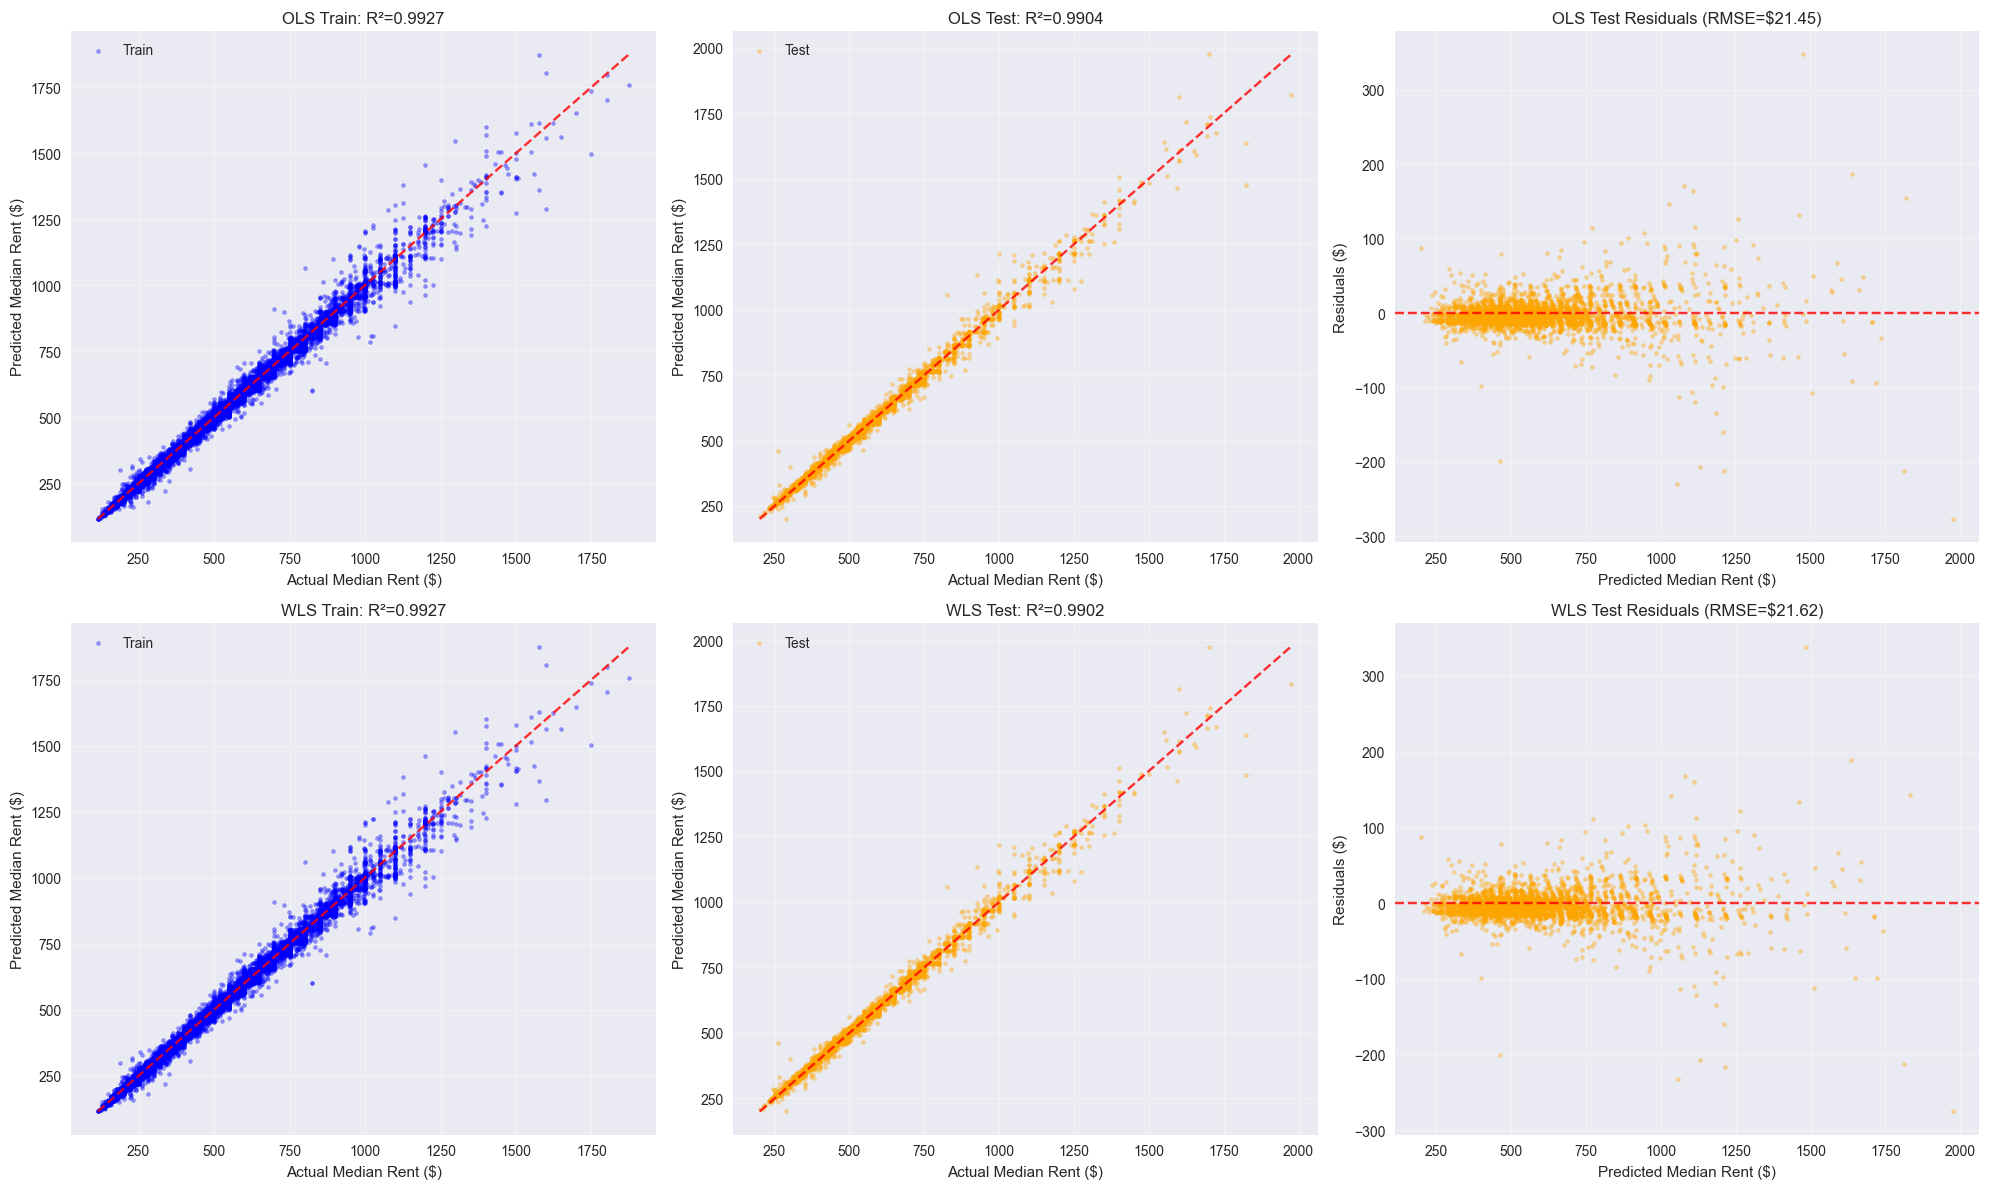

In [21]:
# Residual analysis for TEST set (out-of-sample)
ols_test_residuals = y_test - ols_test_pred
wls_test_residuals = y_test - wls_test_pred

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: OLS
# Plot 1: OLS Train - Actual vs Predicted
axes[0, 0].scatter(y_train, ols_train_pred, alpha=0.4, s=8, color='blue', label='Train')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', alpha=0.8)
axes[0, 0].set_xlabel('Actual Median Rent ($)')
axes[0, 0].set_ylabel('Predicted Median Rent ($)')
axes[0, 0].set_title(f'OLS Train: R²={ols_train_r2:.4f}', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: OLS Test - Actual vs Predicted
axes[0, 1].scatter(y_test, ols_test_pred, alpha=0.4, s=8, color='orange', label='Test')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[0, 1].set_xlabel('Actual Median Rent ($)')
axes[0, 1].set_ylabel('Predicted Median Rent ($)')
axes[0, 1].set_title(f'OLS Test: R²={ols_test_r2:.4f}', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: OLS Test Residuals
axes[0, 2].scatter(ols_test_pred, ols_test_residuals, alpha=0.4, s=8, color='orange')
axes[0, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 2].set_xlabel('Predicted Median Rent ($)')
axes[0, 2].set_ylabel('Residuals ($)')
axes[0, 2].set_title(f'OLS Test Residuals (RMSE=${ols_test_rmse:.2f})', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: WLS
# Plot 4: WLS Train - Actual vs Predicted
axes[1, 0].scatter(y_train, wls_train_pred, alpha=0.4, s=8, color='blue', label='Train')
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', alpha=0.8)
axes[1, 0].set_xlabel('Actual Median Rent ($)')
axes[1, 0].set_ylabel('Predicted Median Rent ($)')
axes[1, 0].set_title(f'WLS Train: R²={wls_train_r2:.4f}', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: WLS Test - Actual vs Predicted
axes[1, 1].scatter(y_test, wls_test_pred, alpha=0.4, s=8, color='orange', label='Test')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[1, 1].set_xlabel('Actual Median Rent ($)')
axes[1, 1].set_ylabel('Predicted Median Rent ($)')
axes[1, 1].set_title(f'WLS Test: R²={wls_test_r2:.4f}', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: WLS Test Residuals
axes[1, 2].scatter(wls_test_pred, wls_test_residuals, alpha=0.4, s=8, color='orange')
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_xlabel('Predicted Median Rent ($)')
axes[1, 2].set_ylabel('Residuals ($)')
axes[1, 2].set_title(f'WLS Test Residuals (RMSE=${wls_test_rmse:.2f})', fontsize=12)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


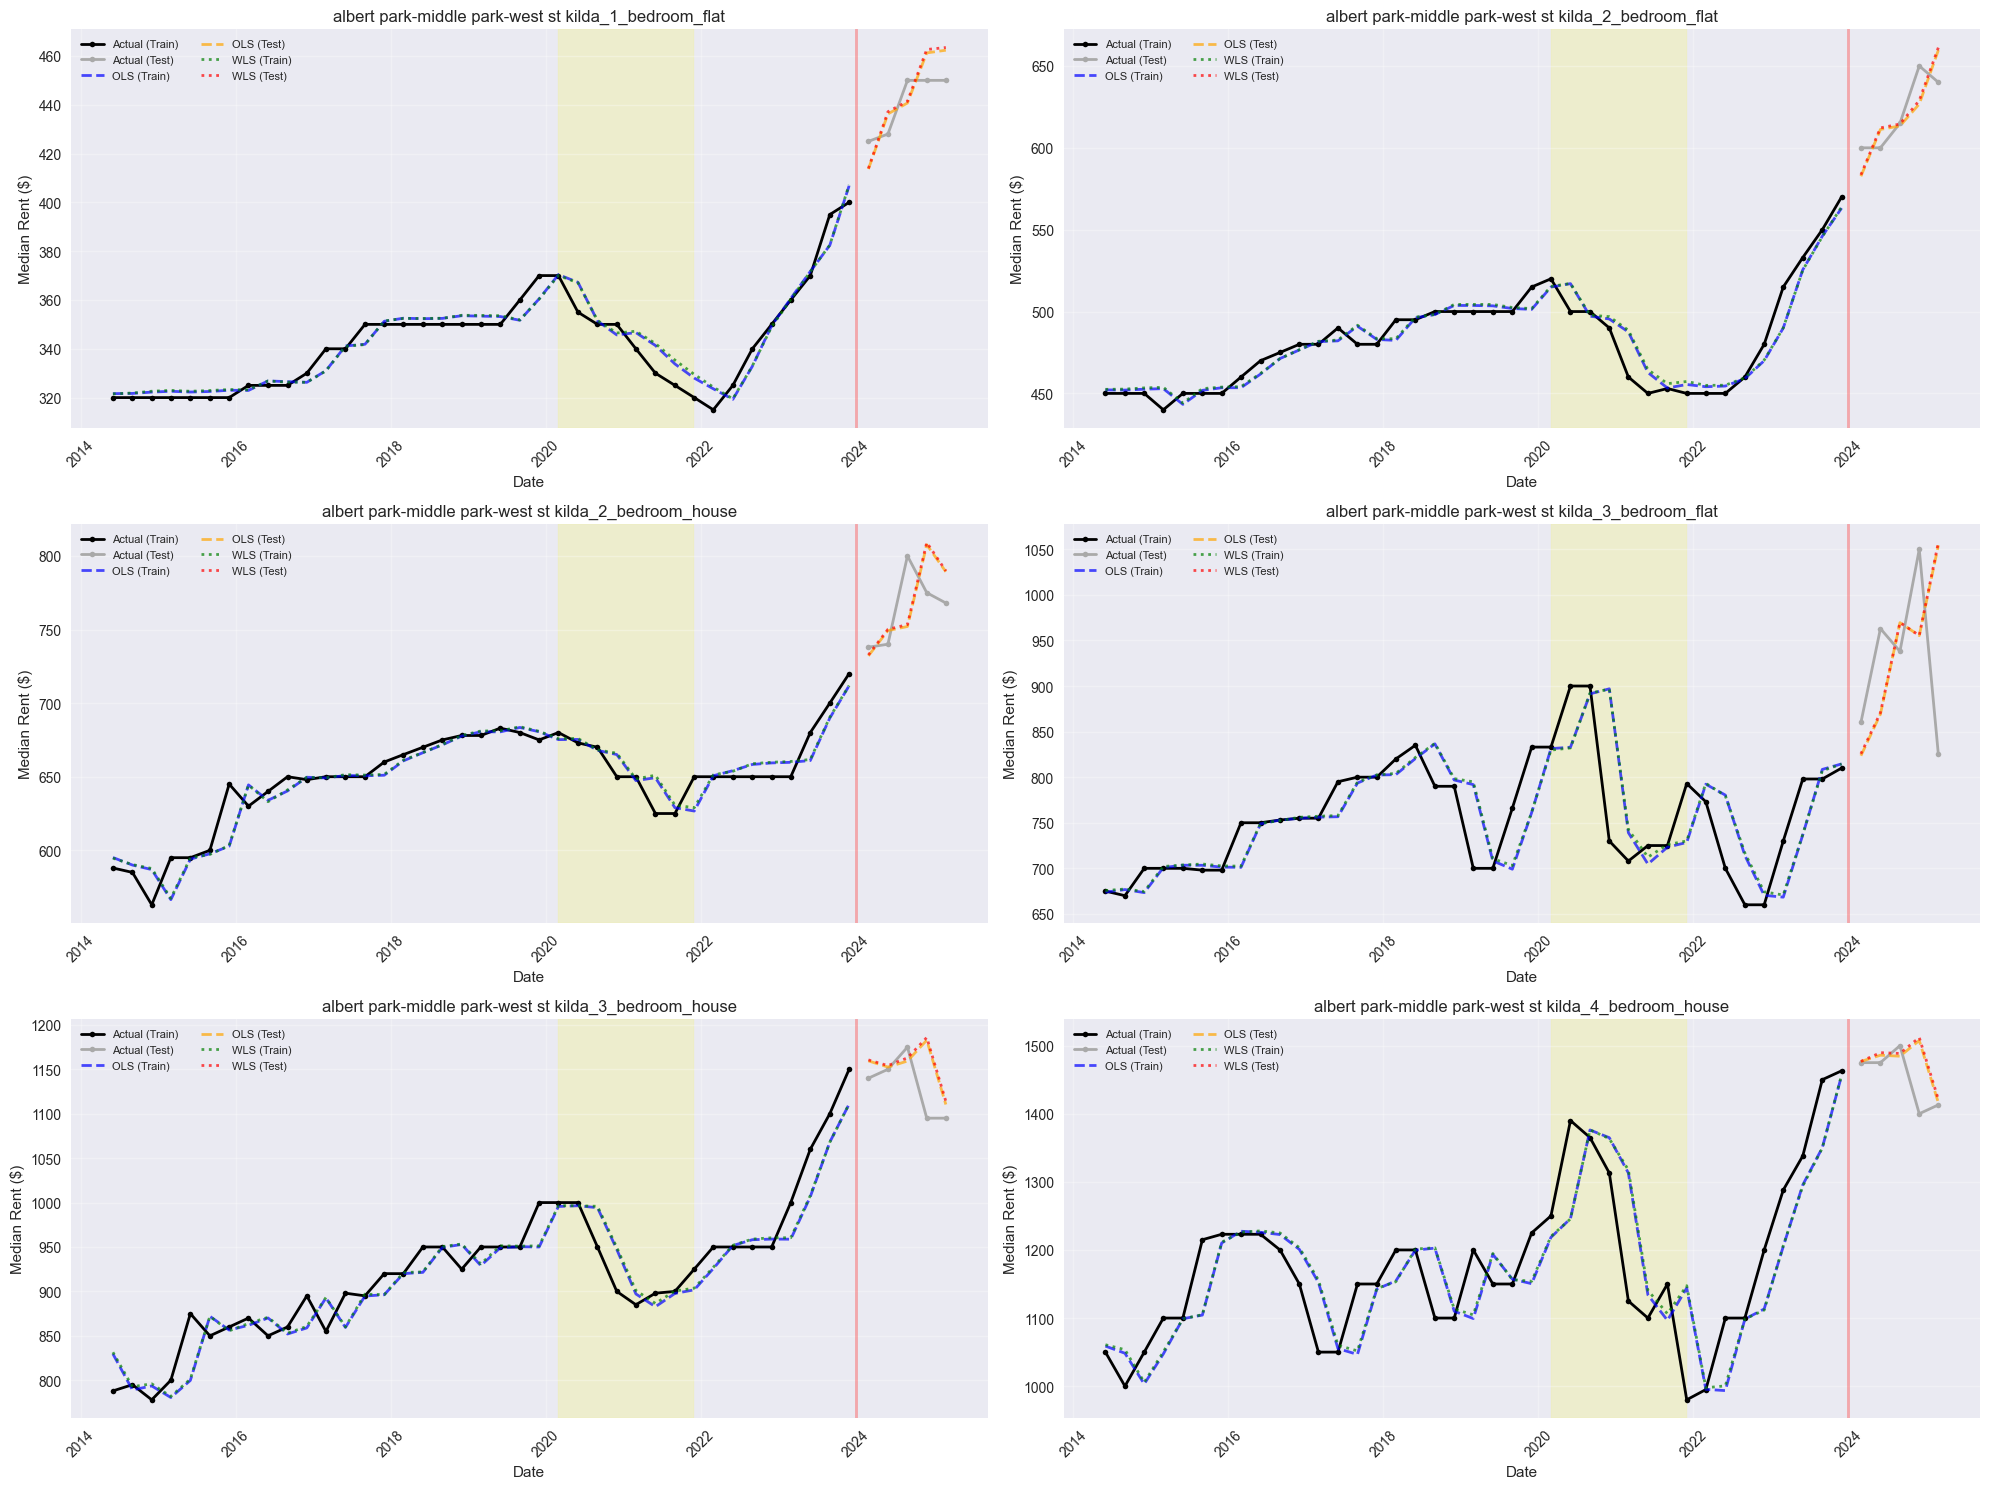

In [22]:
# Time series predictions for sample units - showing train/test split
sample_units = df_clean['spatial_unit'].unique()[:6]

# Combine train and test predictions for plotting
df_train['ols_pred'] = ols_train_pred
df_train['wls_pred'] = wls_train_pred
df_test['ols_pred'] = ols_test_pred
df_test['wls_pred'] = wls_test_pred

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for i, unit in enumerate(sample_units):
    # Get train and test data for this unit
    unit_train = df_train[df_train['spatial_unit'] == unit]
    unit_test = df_test[df_test['spatial_unit'] == unit]
    
    # Plot actual values
    axes[i].plot(unit_train['date'], unit_train['median_rent'], 
                'o-', color='black', label='Actual (Train)', linewidth=2, markersize=4)
    axes[i].plot(unit_test['date'], unit_test['median_rent'], 
                'o-', color='darkgray', label='Actual (Test)', linewidth=2, markersize=4)
    
    # Plot OLS predictions
    axes[i].plot(unit_train['date'], unit_train['ols_pred'], 
                '--', color='blue', label='OLS (Train)', linewidth=2, alpha=0.7)
    if not unit_test.empty:
        axes[i].plot(unit_test['date'], unit_test['ols_pred'], 
                    '--', color='orange', label='OLS (Test)', linewidth=2, alpha=0.7)
    
    # Plot WLS predictions
    axes[i].plot(unit_train['date'], unit_train['wls_pred'], 
                ':', color='green', label='WLS (Train)', linewidth=2, alpha=0.7)
    if not unit_test.empty:
        axes[i].plot(unit_test['date'], unit_test['wls_pred'], 
                    ':', color='red', label='WLS (Test)', linewidth=2, alpha=0.7)
    
    # Add vertical line at train/test split
    axes[i].axvline(x=split_date, color='red', linestyle='-', linewidth=2, alpha=0.3)
    
    # Highlight unreliable period
    unreliable_mask_train = unit_train['is_unreliable']
    if unreliable_mask_train.any():
        unreliable_dates_train = unit_train[unreliable_mask_train]['date']
        axes[i].axvspan(unreliable_dates_train.min(), unreliable_dates_train.max(), 
                       alpha=0.15, color='yellow', zorder=0)
    
    axes[i].set_title(unit, fontsize=12)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Median Rent ($)')
    axes[i].legend(loc='best', fontsize=8, ncol=2)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Clean up temporary columns
df_train.drop(['ols_pred', 'wls_pred'], axis=1, inplace=True)
df_test.drop(['ols_pred', 'wls_pred'], axis=1, inplace=True)


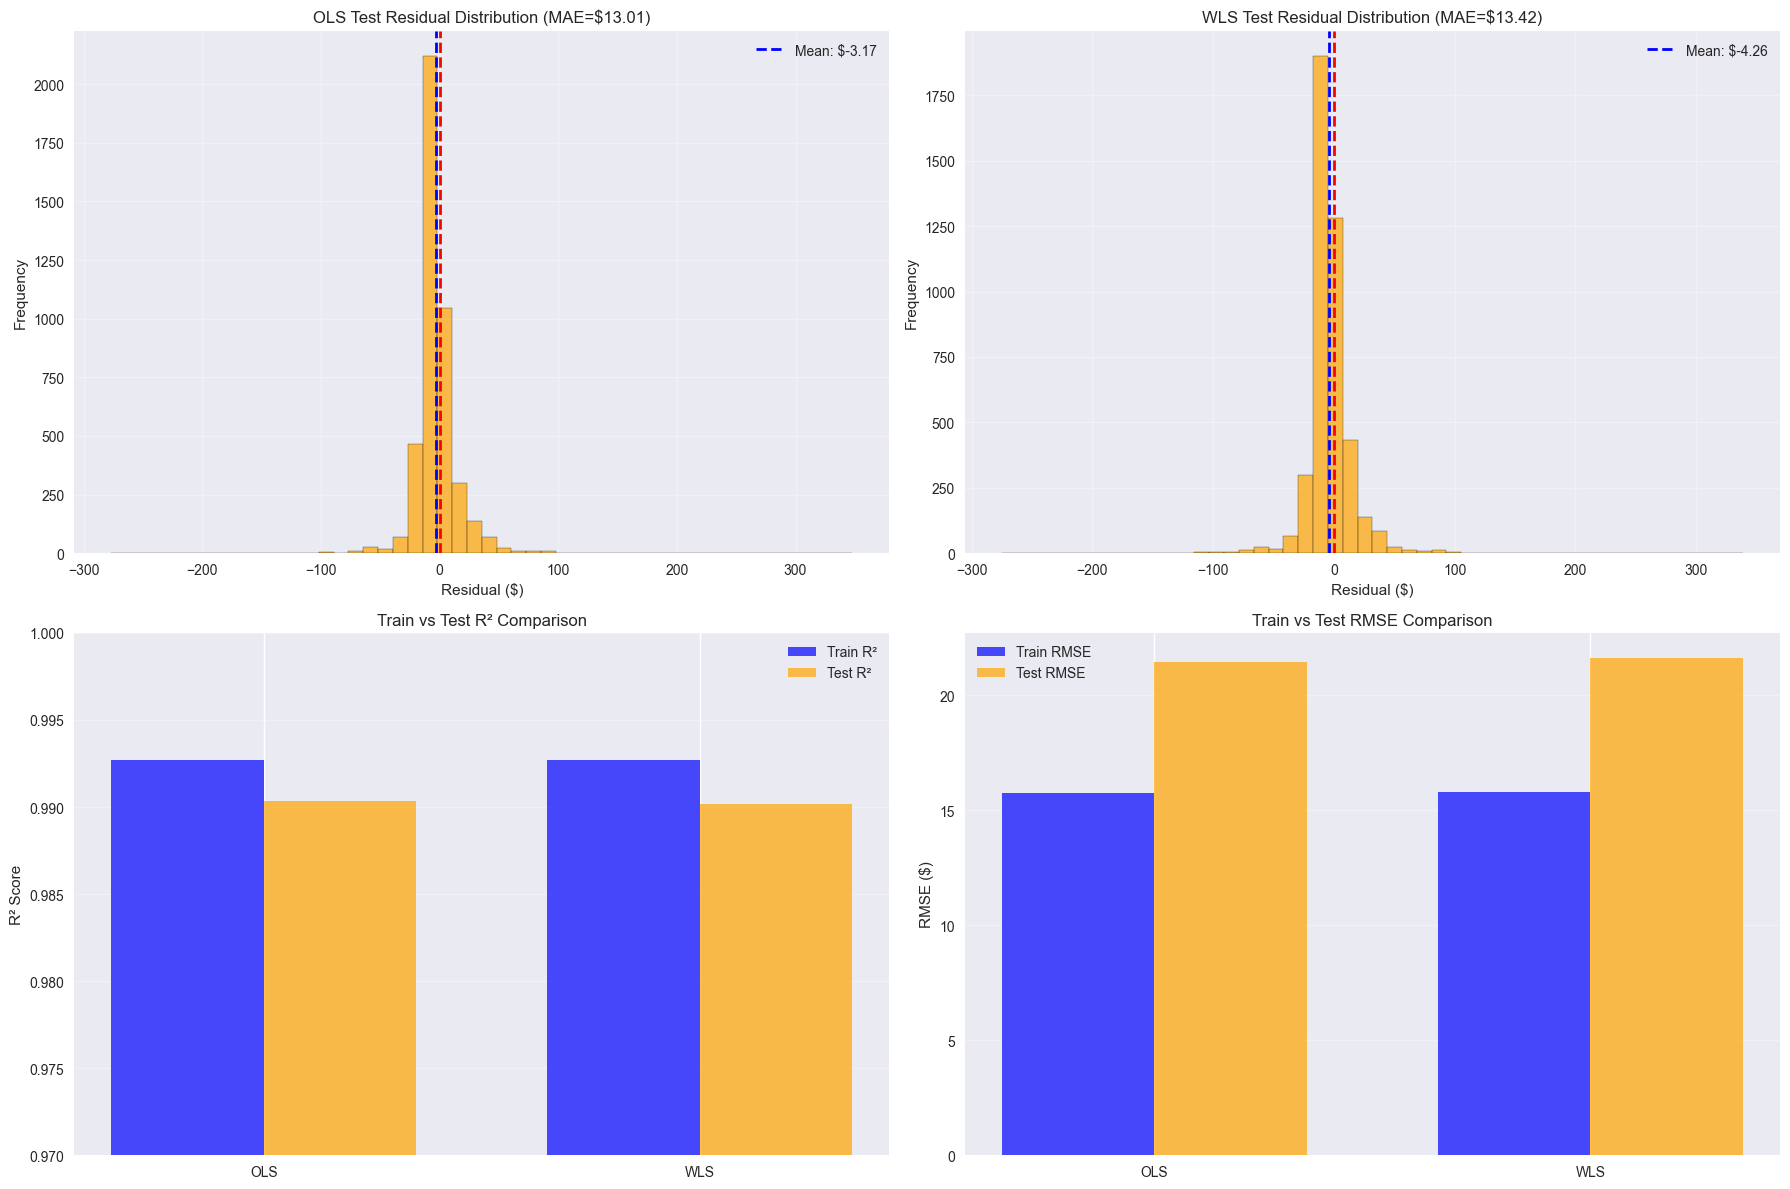

TEST SET PERFORMANCE SUMMARY

OLS Model:
  Residual Mean: $-3.17
  Residual Std: $21.22
  Median Absolute Error: $10.20
  95th Percentile Error: $36.02

WLS Model:
  Residual Mean: $-4.26
  Residual Std: $21.20
  Median Absolute Error: $10.68
  95th Percentile Error: $35.20


In [23]:
# Additional Test Set Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Test Error Distribution - OLS
axes[0, 0].hist(ols_test_residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=ols_test_residuals.mean(), color='blue', linestyle='--', linewidth=2, 
                   label=f'Mean: ${ols_test_residuals.mean():.2f}')
axes[0, 0].set_xlabel('Residual ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'OLS Test Residual Distribution (MAE=${ols_test_mae:.2f})', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test Error Distribution - WLS
axes[0, 1].hist(wls_test_residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=wls_test_residuals.mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: ${wls_test_residuals.mean():.2f}')
axes[0, 1].set_xlabel('Residual ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'WLS Test Residual Distribution (MAE=${wls_test_mae:.2f})', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Performance Comparison Bar Chart
models = ['OLS', 'WLS']
train_r2s = [ols_train_r2, wls_train_r2]
test_r2s = [ols_test_r2, wls_test_r2]

x = np.arange(len(models))
width = 0.35

axes[1, 0].bar(x - width/2, train_r2s, width, label='Train R²', color='blue', alpha=0.7)
axes[1, 0].bar(x + width/2, test_r2s, width, label='Test R²', color='orange', alpha=0.7)
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Train vs Test R² Comparison', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim([0.97, 1.0])  # Zoom in to see differences

# Plot 4: RMSE Comparison
train_rmses = [ols_train_rmse, wls_train_rmse]
test_rmses = [ols_test_rmse, wls_test_rmse]

axes[1, 1].bar(x - width/2, train_rmses, width, label='Train RMSE', color='blue', alpha=0.7)
axes[1, 1].bar(x + width/2, test_rmses, width, label='Test RMSE', color='orange', alpha=0.7)
axes[1, 1].set_ylabel('RMSE ($)')
axes[1, 1].set_title('Train vs Test RMSE Comparison', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics for test set performance
print("=" * 60)
print("TEST SET PERFORMANCE SUMMARY")
print("=" * 60)
print(f"\nOLS Model:")
print(f"  Residual Mean: ${ols_test_residuals.mean():.2f}")
print(f"  Residual Std: ${ols_test_residuals.std():.2f}")
print(f"  Median Absolute Error: ${np.median(np.abs(ols_test_residuals)):.2f}")
print(f"  95th Percentile Error: ${np.percentile(np.abs(ols_test_residuals), 95):.2f}")

print(f"\nWLS Model:")
print(f"  Residual Mean: ${wls_test_residuals.mean():.2f}")
print(f"  Residual Std: ${wls_test_residuals.std():.2f}")
print(f"  Median Absolute Error: ${np.median(np.abs(wls_test_residuals)):.2f}")
print(f"  95th Percentile Error: ${np.percentile(np.abs(wls_test_residuals), 95):.2f}")
print("=" * 60)


=== MODEL COEFFICIENTS ===
                 Feature  OLS Coefficient  WLS Coefficient  OLS P-value  WLS P-value
               Intercept       -16.049283       -20.972556 1.452593e-22 1.061803e-35
property_4 bedroom house         5.796306         4.567955 4.836168e-44 3.030800e-29
          mortgage_rates         4.483053         5.184257 1.129626e-73 7.039869e-74
 property_3 bedroom flat         3.456543         2.949222 1.246511e-23 2.315545e-18
property_3 bedroom house         3.432986         2.410778 5.733423e-23 1.399641e-12
              population        -2.022973        -2.790821 3.834026e-17 3.317918e-16
property_2 bedroom house         1.865568         0.996923 4.186012e-09 1.344265e-03
 property_2 bedroom flat         1.447673         1.362265 2.121893e-06 5.227130e-06
       unemployment_rate        -0.972099        -0.843466 8.982542e-10 1.244772e-08
              rent_lag_1         0.930569         0.921777 0.000000e+00 0.000000e+00
                     gsp         0.748

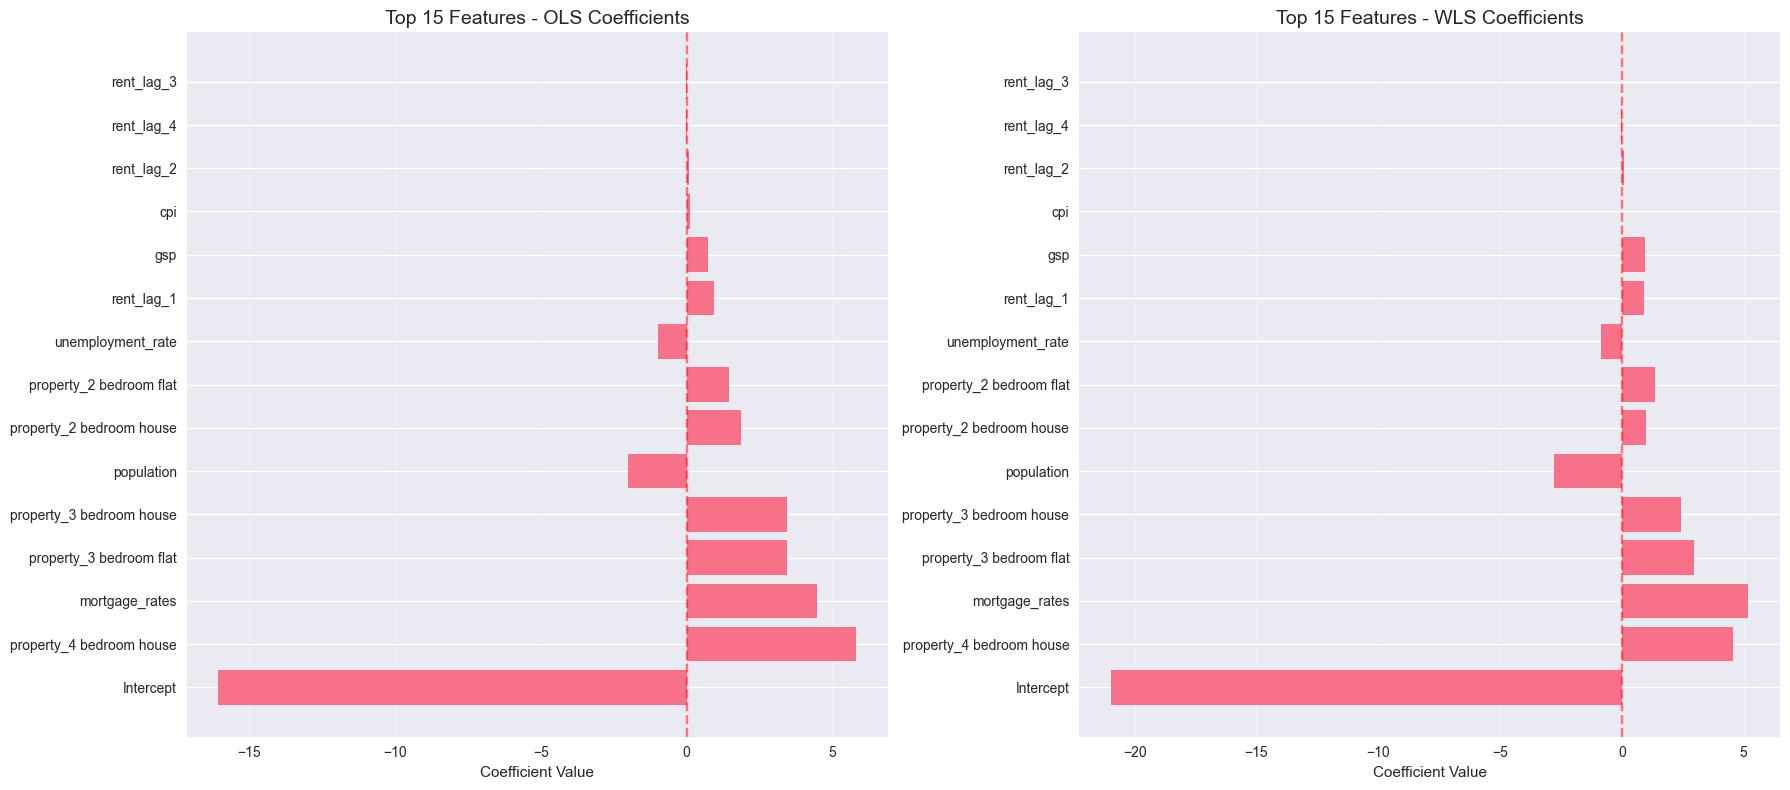

In [24]:
# Feature importance (coefficients)
feature_names = ['Intercept'] + all_features
ols_coefs = ols_model.params
wls_coefs = wls_model.params

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'OLS Coefficient': ols_coefs,
    'WLS Coefficient': wls_coefs,
    'OLS P-value': ols_model.pvalues,
    'WLS P-value': wls_model.pvalues
})

# Sort by absolute OLS coefficient
coef_df['Abs_OLS_Coef'] = np.abs(coef_df['OLS Coefficient'])
coef_df = coef_df.sort_values('Abs_OLS_Coef', ascending=False)

print("=== MODEL COEFFICIENTS ===")
print(coef_df[['Feature', 'OLS Coefficient', 'WLS Coefficient', 'OLS P-value', 'WLS P-value']].to_string(index=False))

# Visualize top coefficients
top_n = min(15, len(coef_df))
top_features = coef_df.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# OLS coefficients
axes[0].barh(range(len(top_features)), top_features['OLS Coefficient'].values)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'].values)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title(f'Top {top_n} Features - OLS Coefficients', fontsize=14)
axes[0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3, axis='x')

# WLS coefficients
axes[1].barh(range(len(top_features)), top_features['WLS Coefficient'].values)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['Feature'].values)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title(f'Top {top_n} Features - WLS Coefficients', fontsize=14)
axes[1].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()
